# Intialize

In [1]:
import classy_sz

In [2]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from classy_sz import Class
import os
import time
from scipy.integrate import simpson
import numpy as np

font = {'size'   : 16, 'family':'STIXGeneral'}
axislabelfontsize='large'
matplotlib.rc('font', **font)
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"]})


def l_to_dl(lp):
    if type(lp) == list:
        lp = np.asarray(lp)
    return lp*(lp+1.)/2./np.pi

In [3]:
import os 
path_to_class_sz = os.environ['PATH_TO_CLASS_SZ_DATA']

path_to_class_sz_files =  path_to_class_sz+"/class_sz/class-sz/class_sz_auxiliary_files/includes/"

## set cosmological parameters

Let us first set the cosmological parameters


In [4]:
cosmo_params = {
'omega_b': 0.022,
'omega_cdm':  0.122,
'H0': 67.5, 
'tau_reio': 0.0561,
'ln10^{10}A_s': 3.047,
'n_s': 0.965,
}

## deal with dndz

- put the relevant file in `path_to_class_sz_files`

In [5]:
zs = np.loadtxt(path_to_class_sz_files+'z_zsplit2.txt')
nzs = np.loadtxt(path_to_class_sz_files+'nz_zsplit2bin0.txt')


- check normalization

In [6]:
if np.trapz(nzs,zs) != 1:
    print(np.trapz(nzs,zs))
    # normalize if not normalized
    nzs_norm = nzs/np.trapz(nzs,zs)
else: 
    nzs_norm


1355882.8763808226


- save in relevant format

In [7]:
np.savetxt(path_to_class_sz_files+'/dndz_quaia.txt',np.c_[zs,nzs_norm])

## quaia bias redshift dependence

Inferred b(z) for quaia from Alonso et al .

In [8]:
@np.vectorize
def bquaia(z,bl):
    return bl*(0.278*((1 + z)**2 - 6.565) + 2.393)

## compute power spectra

In [15]:
class_sz = Class()

class_sz.set(cosmo_params)



common_params = {

# here gal_gal_1h and gal_gal_2h correspond to the HOD calculation
# while gal_gal_hf is the linear bias calculation
# dndlnm ensures we can access the halo-function after computation
'output': 'gal_gal_1h,gal_gal_2h,gal_gal_hf,dndlnm',    

'galaxy_sample' : 'custom', # custom made galaxy sample
'full_path_to_dndz_gal':path_to_class_sz_files+'/dndz_quaia.txt', # redshift distribution of custom made galaxy sample

# pick redshift range
'z_min' : 0.005,
'z_max' : 3.0,
    
'has_b_custom1': 1, # do you want a cutom function for b(z)? yes: 1, no: 0
'array_b_custom1_n_z': 200, # precision parameters for z sampling of b(z)    
'non_linear' : 'hmcode', # non-linear model for matter P(k), e.g., 'hmcode' or 'halofit'
'effective_galaxy_bias': 2.,
# for the custom bias function we want: 
# b(z) = bquaia(z,bl) as defined above and bl is effective_galaxy_bias
# We code this in path_to_classy_szfast/classy_szfast/custom_bias/custom_bias.py
    
    
# pick mass range (relevant for HOD prediction)
'M_min' : 1e11, 
'M_max' : 1e15,
    

    
# Other parameters relevant for HOD predictions
'mass_function' : 'T08M200c', # halo mass function, e.g., Tinker et al 2008 defined at M200c
'concentration_parameter' : 'B13', # halo concentration parameter  

# main HOD parameters controlling Nc, Ns
'sigma_log10M_HOD': 0.68,
'alpha_s_HOD':    1.30,
'M1_prime_HOD': 10**12.7, # msun/h
'M_min_HOD': 10**11.8, # msun/h
'M0_HOD' :0,

"p_max_elg_hod": 0.18,
"Q_elg_hod": 100., 
"gamma_elg_hod": 6.12,
"use_elg_hod_model": 1,
    
# these are not important (maybe for fine-tuning HOD)
'x_out_truncated_nfw_profile_satellite_galaxies':  1.,
'f_cen_HOD' : 1., 

'hm_consistency' : 0,


'dlogell' : 0.1,
'ell_max' : 10000.0,
'ell_min' : 2.0,


    
}

# if you need other cosmological parameters
# do: 
cosmo_params.update(
{
'omega_cdm':0.11,

'cosmo_model': 1,
    
'skip_background_and_thermo': 0,
'N_ncdm': 1,
'N_ur': 2.0308,
'm_ncdm': 0.06,    
'deg_ncdm': 1,
'skip_input': 0,
}
)

class_sz.set(common_params)


True

In [16]:
%%time
class_sz.compute_class_szfast()

/Users/boris/venvdir/class_sz_312_brew/lib/python3.12/site-packages/IPython/core/magics/execution.py:1317: DeprecationWarning: compute_class_szfast is deprecated. Use initialize_classy_szfast instead.
  out = eval(code, glob, local_ns)
/Users/boris/venvdir/class_sz_312_brew/lib/python3.12/site-packages/mcfit/mcfit.py:130: UserWarning: use backend='jax' if desired
  warnings.warn("use backend='jax' if desired")


CPU times: user 24.3 s, sys: 1.58 s, total: 25.9 s
Wall time: 3.15 s


In [17]:
## check why returns 0?
# class_sz.get_current_derived_parameters(['m_ncdm_tot'])

In [18]:
class_sz.Neff()

3.045997909268964

## collect the output

In [19]:
# factor for converting to cl


# linear bias calculations
l, cl_gg_linear_bias = np.asarray(class_sz.cl_gg()['ell']),np.asarray(class_sz.cl_gg()['hf'])
cl_gg_linear_bias /= l_to_dl(l)


# hod calculation
l, cl_gg_hod_1h, cl_gg_hod_2h = np.asarray(class_sz.cl_gg()['ell']),np.asarray(class_sz.cl_gg()['1h']),np.asarray(class_sz.cl_gg()['2h'])
cl_gg_hod_tot = cl_gg_hod_1h + cl_gg_hod_2h
cl_gg_hod_tot /= l_to_dl(l)
cl_gg_hod_1h /= l_to_dl(l)
cl_gg_hod_2h /= l_to_dl(l)

## plot

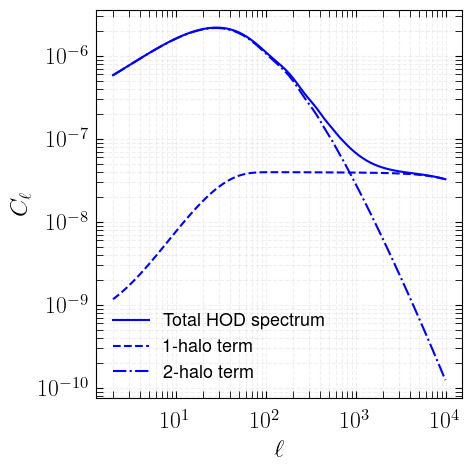

In [21]:
label_size = 17
title_size = 18
legend_size = 13
handle_length = 1.5
fig, (ax1) = plt.subplots(1,1,figsize=(5,5))


ax = ax1
ax.tick_params(axis = 'x',which='both',length=5,direction='in', pad=10)
ax.tick_params(axis = 'y',which='both',length=5,direction='in', pad=5)
ax.xaxis.set_ticks_position('both')
ax.yaxis.set_ticks_position('both')
plt.setp(ax.get_yticklabels(), rotation='horizontal', fontsize=label_size)
plt.setp(ax.get_xticklabels(), fontsize=label_size)
ax.grid( visible=True, which="both", alpha=0.2, linestyle='--')
ax.set_ylabel(r"$C_\ell$ ",size=title_size)
ax.set_xlabel(r"$\ell$",size=title_size)
ax.set_xscale('log')
ax.set_yscale('log')

plt.loglog(l, cl_gg_hod_tot,ls='-', label='Total HOD spectrum',c='blue')
plt.loglog(l, cl_gg_hod_1h,ls='--', label='1-halo term',c='blue')
plt.loglog(l, cl_gg_hod_2h,ls='-.', label='2-halo term',c='blue')


# plt.loglog(l, cl_gg_linear_bias, label='Total linear-bias spectrum',c='r')



# plt.ylim(1e-2,1e4)

ax.legend(fontsize=11,ncol=1,frameon=False)




ax.legend(fontsize=13,ncol=1,frameon=False)
fig.tight_layout()

In [22]:
zx = 1.
ngbar = class_sz.get_ng_bar_at_z(zx)
print(f'ngbar = {ngbar}')

ngbar = 0.000947370600123072


In [23]:
marr = np.geomspace(common_params['M_min'],common_params['M_max'],500)

M_min = common_params['M_min_HOD']
sigma_log10M = common_params['sigma_log10M_HOD']
fc = common_params['f_cen_HOD']


get_nc = np.vectorize(class_sz.get_N_centrals)
nc = get_nc(zx,marr,M_min,sigma_log10M,fc).squeeze()


get_ns = np.vectorize(class_sz.get_N_satellites)

alpha_s = common_params['alpha_s_HOD']
m1p = common_params['M1_prime_HOD']
ns = get_ns(zx,marr,nc,M_min,alpha_s,m1p)

Text(0, 0.5, 'Nc,Ns')

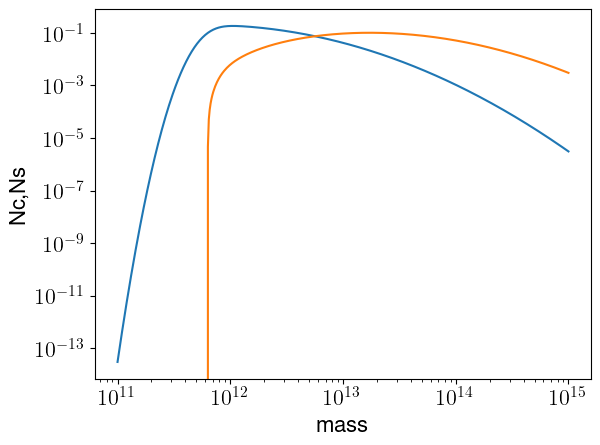

In [24]:
plt.plot(marr,nc)
plt.plot(marr,ns)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('mass')
plt.ylabel('Nc,Ns')